# Анализ поведения пользователей мобильного приложения

**Описание проекта**

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 
Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

**Описание данных**

Каждая запись в логе — это действие пользователя, или событие. 
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


Составим небольшой план исследования. 

**План исследования:**
1. Предобработка данных: проверим набор данных на пропуски и дубли, чтобы исследования было более честным. 
2. Проанализируем данные:
    - группы пользователей
    - среднее количество посещений
    - посмотрим полноту данных за весь прериод, скорректируем его при надобности
    - рассмотрим распределение пользователей по этапам 
    - составим воронку продаж
3. По результатам прошлого этапа выдвиним гипотезы, которые будем проверять
4. Сделаем вывод по исследованию и выдвинутым гипотезам
    

## Предобработка данных

In [1]:
import pandas as pd 
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import stats as st
import math as mth
import plotly.express as px

#Загрузка данных 
data = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')
data.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [2]:
#Перед работой переименуем название столбцов для удобной работы
data.columns=['event_name','device_id','event_dt','experiment_id']
data.info()
#Столбец event_dt имеет неправильный тип, преобразуем его в формат даты
data['event_dt']= pd.to_datetime(data['event_dt'], unit='s')

#Проверим данные на дубликаты и пропуски
print ("Кол-во дубликатов: ", data.duplicated().sum())
print ("Кол-во пропусков: ")
print(data.isnull().sum())

#Удаляем дубликаты
data = data.drop_duplicates()
print ("Кол-во дубликатов после удаления: ", data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   event_name     244126 non-null  object
 1   device_id      244126 non-null  int64 
 2   event_dt       244126 non-null  int64 
 3   experiment_id  244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
Кол-во дубликатов:  413
Кол-во пропусков: 
event_name       0
device_id        0
event_dt         0
experiment_id    0
dtype: int64
Кол-во дубликатов после удаления:  0


Для удобства также выделим дату в отдельный столбец

In [3]:
data['dt'] = data['event_dt'].dt.date

data.head(5)

,event_name,device_id,event_dt,experiment_id,dt
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


В блоке предобработки данных мы: 
- Заменили названия столбцов на удобные для нас;
- Проверили пропуски и типы данных, откорретировали не верные 
- Добавили столбец даты и времени, а также отдельный столбец дат;

## Изучение и проверка данных

В этом блоке ответим на несколько важные для дальнейшего изучения вопросов: 
### Сколько всего событий в логе?

In [4]:
print("В логе всего",data['event_name'].count(),"событий")
print("Неповторяющих значений из них", len(np.unique(data['event_name'])))

В логе всего 243713 событий
Неповторяющих значений из них 5


###  Сколько всего пользователей в логе?

In [5]:
print("В логе всего",len(np.unique(data['device_id'])), "пользователей")

В логе всего 7551 пользователей


### Сколько в среднем событий приходится на пользователя?

In [6]:
event_id = data.groupby(by='device_id').agg({'event_dt':'count'})

print("В среднем на одного пользователя приходится", round(event_id['event_dt'].mean(),2), "событий")


В среднем на одного пользователя приходится 32.28 событий


### Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?

Минимальная дата: 2019-07-25 04:43:36
Максимальная дата: 2019-08-07 21:15:17


(array([26762., 19519., 25588., 28596., 15797., 22463., 32605., 18642.,
        22071., 28844.]),
 array([18109.00518519, 18109.69322801, 18110.38127083, 18111.06931366,
        18111.75735648, 18112.44539931, 18113.13344213, 18113.82148495,
        18114.50952778, 18115.1975706 , 18115.88561343]),
 <BarContainer object of 10 artists>)

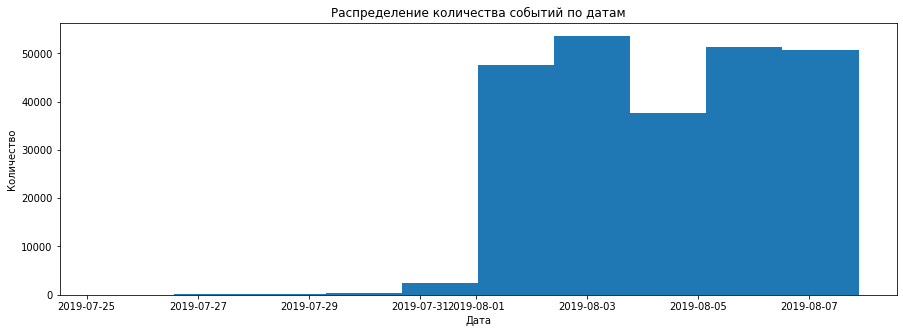

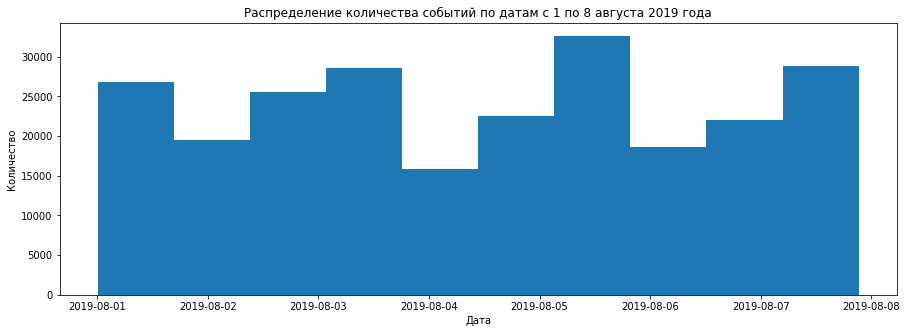

In [7]:
#Найдем минимальную и максимальную даты
print("Минимальная дата:", data['event_dt'].min())
print("Максимальная дата:", data['event_dt'].max())

#Построем их распределение с помощью гистограммы
plt.figure(figsize=(15,5))
plt.title ("Распределение количества событий по датам")
plt.xlabel("Дата")
plt.ylabel("Количество")
plt.hist(data['event_dt'])

#Посмотрим период с 01.08.2019 года
data_au2019 = data.query("event_dt >= '2019-08-01'")

plt.figure(figsize=(15,5))
plt.title ("Распределение количества событий по датам c 1 по 8 августа 2019 года")
plt.xlabel("Дата")
plt.ylabel("Количество")
plt.hist(data_au2019['event_dt'])

Минимальная дата: 2019-07-25 04:43:36

Максимальная дата: 2019-08-07 21:15:17

Но при просмотре гистограммы распределения по датам можно увидеть, что до 1 августа 2019 года количество операций было очень мало. Поэтому по сути минимальная дата 1 августа 2019 года, с которого мы получим более точным и полный анализ. 
Получается, что мы располагаем данными в период с 1 августа по 7 августа 2019 года. 

###  Много ли событий и пользователей вы потеряли, отбросив старые данные?

In [8]:
data_ju2019 = data.query("event_dt < '2019-08-01'")

Также посмотрим потерю по уникальным пользователям. 

In [9]:
'''count = 0 
for i in data_ju2019:
    if i not in data_au2019['device_id'].unique():
        count+=1

print("Количество пользователей, которые мы упускаем:", count)'''       

'count = 0 \nfor i in data_ju2019:\n    if i not in data_au2019[\'device_id\'].unique():\n        count+=1\n\nprint("Количество пользователей, которые мы упускаем:", count)'

In [10]:
#print('Событий было: ', data.shape[0])
#print('Стало событий после того как отбросили данные: ', data_au2019.shape[0])
print('Количество событий, которые мы упустили: ', data.shape[0]-data_au2019.shape[0])

#print('Пользователей было: ',data['device_id'].nunique())
#print('Стало пользователей после того как отбросили данные: ',data_au2019['device_id'].nunique())
print('Количество пользователей, которые мы упустили: ',data['device_id'].nunique()-data_au2019['device_id'].nunique())

print(f"Доля потери событий: {round((data.shape[0]-data_au2019.shape[0])/data.shape[0]*100,1)}%")
print(f"Доля потеренных пользователей: {round((data['device_id'].nunique()-data_au2019['device_id'].nunique())/data['device_id'].nunique()*100,1)}%")

Количество событий, которые мы упустили:  2826
Количество пользователей, которые мы упустили:  17
Доля потери событий: 1.2%
Доля потеренных пользователей: 0.2%


При обрасывании периода до 1 августа 2019 года мы упускаем всего 1% событий и 0.2% пользователей, это очень маленький процент, поэтому можно смело отбрасывать данный период 

In [11]:
# код ревьюера
new_logs = data.query('event_dt >= "2019-08-01"')

In [12]:
# код ревьюера
print('Событий было: ', data.shape[0])
print('Пользователей было: ',data['device_id'].nunique())
print('Событий после того как отбросили данные: ', new_logs.shape[0])
print('Пользователей после того как отбросили данные: ',new_logs['device_id'].nunique())


Событий было:  243713
Пользователей было:  7551
Событий после того как отбросили данные:  240887
Пользователей после того как отбросили данные:  7534


### Проверим, есть ли пользователи из всех трёх экспериментальных групп.

In [13]:
#Сгруппируем данные по номеру эксперементальной группы, чтобы узнать, какие из номер встречаются

print("Эксперементальные группы:")
print(data_ju2019.groupby(by='experiment_id').agg({'experiment_id':'count'}))

Эксперементальные группы:
               experiment_id
experiment_id               
246                      879
247                      928
248                     1019


При изучении данных мы обнаружили, что в наборе данных события начинают фиксироваться с 25 июля 2019 года по 7 августа 2019 года. Также нам удалось выяснить, что не в весь период события происходили равномерно: в период с 25 июля по 1 августа они имеют очень маленькое количество. Так для дальнейшего анализа мы исключим данные до 1 августа 2019 году. Также проанализировав, полученный набор, которые мы решили исключить, мы узнали, что в дальнейший анализ не войдет 2826 событий, которые принадлежат всем трем экспериментальным группам. 

## Изучим воронку событий

### Посмотрим, какие события есть в логах, как часто они встречаются.

In [14]:
print("Виды событий в логах и их частота:")

#Сгруппируем набор по сназваниям событий и посчитаем количество их появлений
au2019_group = data_au2019.groupby(by = 'event_name').agg({'event_name':'count'})
au2019_group.columns=['count']

print (au2019_group.sort_values(by = 'count',ascending=False))

Виды событий в логах и их частота:
                          count
event_name                     
MainScreenAppear         117328
OffersScreenAppear        46333
CartScreenAppear          42303
PaymentScreenSuccessful   33918
Tutorial                   1005


Частота появления самого популярного этапа  равно 117 328, которым является MainScreenAppear

Самого непопулярного Tutorial всего 1005 

### Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

In [15]:
#Посчитаем уникальное количество пользователей. 
au2019_group = data_au2019.groupby(by = 'event_name').agg(
    {'device_id':'nunique'})
au2019_group.columns = ['count']

#Добавим новый столбец с вычислением процента от общего числа пользователей. 
au2019_group['procent'] = round((au2019_group['count']/len(data_au2019['device_id'].unique())) * 100,2)
print (au2019_group.sort_values(by = 'count',ascending=False))


                         count  procent
event_name                             
MainScreenAppear          7419    98.47
OffersScreenAppear        4593    60.96
CartScreenAppear          3734    49.56
PaymentScreenSuccessful   3539    46.97
Tutorial                   840    11.15


Для более наглядного представление построим круговую гистограмму по процентам

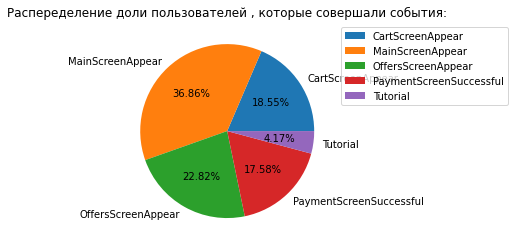

In [16]:
plt.title("Распеределение доли пользователей , которые совершали события:")
plt.pie(au2019_group['procent'],labels = np.unique(data['event_name']), autopct='%1.2f%%')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

Теперь на круговой диаграмме наглядно видно, что самым популярным этапом является MainScreenAppear, который составляет 36,86% от общего количества. Самым непопулярный - Tutorial, который имеет 4,17%

### Предположем, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

### По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [17]:
au2019_voronka = data_au2019.pivot_table(index = 'event_name', values='device_id',aggfunc='nunique')
au2019_voronka.columns=['device_id']
au2019_voronka['conversion']=0
for i in range(0, len(au2019_voronka['device_id'])):
    if i == 0:
        au2019_voronka['conversion']=100
    else:
        au2019_voronka['conversion'][i] = round((au2019_voronka['device_id'][i]/au2019_voronka['device_id'][i-1]),2)*100

au2019_voronka.sort_values(by='conversion', ascending=False)

,device_id,conversion
event_name,,
MainScreenAppear,7419,199
CartScreenAppear,3734,100
PaymentScreenSuccessful,3539,77
OffersScreenAppear,4593,62
Tutorial,840,24


На воронке продаж мы видим, что самая большая конверсия у этапа перехода на главный этап. Самым не популярным является руководство в использовании. Это вполне логично, так как маленькое количество людей пользуются интрукцией и спешат самостоятельно попробовать приложение. 

### На каком шаге теряете больше всего пользователей?

Мы видем, что на этапе Tutorial отбрасываются больше всего пользователей.

### Какая доля пользователей доходит от первого события до оплаты?

In [18]:
print('Доля пользователей, которые доходят до оплаты', \
      round(au2019_group['count'].iloc[3]/au2019_group['count'].iloc[0], 2)*100, "%")

Доля пользователей, которые доходят до оплаты 95.0 %


## Изучение результатов эксперимента

### Изучим результаты эксперимента

In [19]:
exp_group_one = data_au2019.pivot_table(index = 'experiment_id', values='device_id',aggfunc='nunique')

exp_group = data_au2019.pivot_table(index='experiment_id',columns = 'event_name', values='device_id',aggfunc='nunique')

exp_group = exp_group.merge(exp_group_one, left_on='experiment_id', right_on='experiment_id')


exp_group

,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,device_id
experiment_id,,,,,,
246,1266,2450,1542,1200,278,2484
247,1238,2476,1520,1158,283,2513
248,1230,2493,1531,1181,279,2537


Тут мы видим, что из исследования можно исключить этап Tutorial, так как до него доходит очень маленькое количество человек и к тому же они почти равны для разных эксперементальных групп. 

In [20]:
del exp_group['Tutorial']

exp_group

,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,device_id
experiment_id,,,,,
246,1266,2450,1542,1200,2484
247,1238,2476,1520,1158,2513
248,1230,2493,1531,1181,2537


In [33]:
from plotly import graph_objects as go

fig = go.Figure()

fig.add_trace(go.Funnel(
    name = '246',
    y = ["MainScreenAppear", "OffersScreenAppear", "CartScreenAppear", "PaymentScreenSuccessful"],
    x = [exp_group.iloc[0]['MainScreenAppear'],exp_group.iloc[0]['OffersScreenAppear'],exp_group.iloc[0]['CartScreenAppear'],exp_group.iloc[0]['PaymentScreenSuccessful']],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = '247',
    orientation = "h",
    y = ["MainScreenAppear", "OffersScreenAppear", "CartScreenAppear", "PaymentScreenSuccessful"],
    x = [exp_group.iloc[1]['MainScreenAppear'],exp_group.iloc[1]['OffersScreenAppear'],exp_group.iloc[1]['CartScreenAppear'],exp_group.iloc[1]['PaymentScreenSuccessful']],
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = '248',
    orientation = "h",
    y = ["MainScreenAppear", "OffersScreenAppear", "CartScreenAppear", "PaymentScreenSuccessful"],
    x = [exp_group.iloc[2]['MainScreenAppear'],exp_group.iloc[2]['OffersScreenAppear'],exp_group.iloc[2]['CartScreenAppear'],exp_group.iloc[2]['PaymentScreenSuccessful']],
    textposition = "outside",
    textinfo = "value+percent total"))
# Код ревьюера
fig.update_layout(title='Воронка')

Теперь мы четко видем, что первый шаг проходят, то есть появление первого экрана **MainScreenAppear**. 

Проверим не пересекаются ли участники разных групп между собой.

In [22]:
#для проверки сгруппируем пользователей и посчитаем количество группы для каждого
data_au2019.groupby('device_id').agg({'experiment_id':'nunique'}).query('experiment_id > 1') 

,experiment_id
device_id,


Мы получили пустой набор данных, то есть пользователи разных эксперементальных групп не пересекаются между собой, так что можно подолжить исследования дальше

In [23]:
# Код ревьюера
# Проверим пользователей, которые могли участвовать в двух или нескольких группах одновременно:
data_au2019.groupby('device_id').agg({'experiment_id':'nunique'}).query('experiment_id > 1') 


,experiment_id
device_id,


### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

Выдвеним нулевую гипотезу: статистические критерии разница между выборками 246 и 247 присутвует, доли не равны 

Альтернативная гипотеза: статистические критерии разница между выборками 246 и 247 отсутвует

In [24]:
#Для упрощения сделаем функция, которая считает результат проверки гипотезы

def return_examination(purchases,leads,alpha):
    
    p1 = purchases[0]/leads[0]
    p2 = purchases[1]/leads[1]
    
    p_combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])
    
    difference = p1 - p2 
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))
    
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

       

In [25]:
count_users = ([exp_group['device_id'].iloc[0], exp_group['device_id'].iloc[1]])
MainScreenAppear = ([exp_group['MainScreenAppear'].iloc[0], exp_group['MainScreenAppear'].iloc[1]])
OffersScreenAppear = ([exp_group['OffersScreenAppear'].iloc[0], exp_group['OffersScreenAppear'].iloc[1]])
CartScreenAppear = ([exp_group['CartScreenAppear'].iloc[0], exp_group['CartScreenAppear'].iloc[1]])
PaymentScreenSuccessful = ([exp_group['PaymentScreenSuccessful'].iloc[0], exp_group['PaymentScreenSuccessful'].iloc[1]])

print('Результаты сравнения долей общего количества и MainScreenAppear по группа:')
return_examination(MainScreenAppear, count_users, 0.05)

print()
print('Результаты сравнения долей общего количества и OffersScreenAppear по группа:')
return_examination(OffersScreenAppear, count_users, 0.05)
  
print()
print('Результаты сравнения долей общего количества и CartScreenAppear по группа:')
return_examination(CartScreenAppear, count_users, 0.05)

print()
print('Результаты сравнения долей общего количества и PaymentScreenSuccessful по группа:')
return_examination(PaymentScreenSuccessful, count_users, 0.05)

Результаты сравнения долей общего количества и MainScreenAppear по группа:
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты сравнения долей общего количества и OffersScreenAppear по группа:
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты сравнения долей общего количества и CartScreenAppear по группа:
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты сравнения долей общего количества и PaymentScreenSuccessful по группа:
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Как мы видем в ходе иследования не получается опровергнуть нулевую гипотезу. 

**Статистические критерии разница между выборками 246 и 247 отсутсвует**

### Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

Так мы уже определили выше: самым популярным этапам является **MainScreenAppear**

### Аналогично поступим с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой и сделаем выводы

Гипотезу оставляем прежней. 

In [26]:
#Сравним 246 и 248

count_users = ([exp_group['device_id'].iloc[0], exp_group['device_id'].iloc[2]])
MainScreenAppear = ([exp_group['MainScreenAppear'].iloc[0], exp_group['MainScreenAppear'].iloc[2]])
OffersScreenAppear = ([exp_group['OffersScreenAppear'].iloc[0], exp_group['OffersScreenAppear'].iloc[2]])
CartScreenAppear = ([exp_group['CartScreenAppear'].iloc[0], exp_group['CartScreenAppear'].iloc[2]])
PaymentScreenSuccessful = ([exp_group['PaymentScreenSuccessful'].iloc[0], exp_group['PaymentScreenSuccessful'].iloc[2]])
alpha=0.1

print('Результаты сравнения долей общего количества и MainScreenAppear по группа:')
return_examination(MainScreenAppear, count_users, alpha=0.1)

print()
print('Результаты сравнения долей общего количества и OffersScreenAppear по группа:')
return_examination(OffersScreenAppear, count_users, alpha=0.1)
  
print()
print('Результаты сравнения долей общего количества и CartScreenAppear по группа:')
return_examination(CartScreenAppear, count_users, alpha=0.1)

print()
print('Результаты сравнения долей общего количества и PaymentScreenSuccessful по группа:')
return_examination(PaymentScreenSuccessful, count_users, alpha=0.1)

Результаты сравнения долей общего количества и MainScreenAppear по группа:
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты сравнения долей общего количества и OffersScreenAppear по группа:
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты сравнения долей общего количества и CartScreenAppear по группа:
p-значение:  0.07842923237520116
Отвергаем нулевую гипотезу: между долями есть значимая разница

Результаты сравнения долей общего количества и PaymentScreenSuccessful по группа:
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По шагам MainScreenAppear, OffersScreenAppear, PaymentScreenSuccessful нельзя опровергнуть нулевую гипотезу. Поэтому можно считать, что **статистические критерии разница между выборками 246 и 248 отсутсвует**

In [27]:
#Сравним 247 и 248

count_users = ([exp_group['device_id'].iloc[1], exp_group['device_id'].iloc[2]])
MainScreenAppear = ([exp_group['MainScreenAppear'].iloc[1], exp_group['MainScreenAppear'].iloc[2]])
OffersScreenAppear = ([exp_group['OffersScreenAppear'].iloc[1], exp_group['OffersScreenAppear'].iloc[2]])
CartScreenAppear = ([exp_group['CartScreenAppear'].iloc[1], exp_group['CartScreenAppear'].iloc[2]])
PaymentScreenSuccessful = ([exp_group['PaymentScreenSuccessful'].iloc[1], exp_group['PaymentScreenSuccessful'].iloc[2]])

print('Результаты сравнения долей общего количества и MainScreenAppear по группа:')
return_examination(MainScreenAppear, count_users, alpha=0.1)

print()
print('Результаты сравнения долей общего количества и OffersScreenAppear по группа:')
return_examination(OffersScreenAppear, count_users, alpha=0.1)
  
print()
print('Результаты сравнения долей общего количества и CartScreenAppear по группа:')
return_examination(CartScreenAppear, count_users, alpha=0.1)

print()
print('Результаты сравнения долей общего количества и PaymentScreenSuccessful по группа:')
return_examination(PaymentScreenSuccessful, count_users, alpha=0.1)

Результаты сравнения долей общего количества и MainScreenAppear по группа:
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты сравнения долей общего количества и OffersScreenAppear по группа:
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты сравнения долей общего количества и CartScreenAppear по группа:
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты сравнения долей общего количества и PaymentScreenSuccessful по группа:
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Аналогичный результат мы получаем и при рассмотрении групп 247 и 248. Нулевую гипотезу не опровергаем!

In [28]:
#Создадим новую строку с суммой первых двух групп

exp_group.loc['sum'] = [exp_group['CartScreenAppear'].iloc[0]+exp_group['CartScreenAppear'].iloc[1] , exp_group['MainScreenAppear'].iloc[0]+exp_group['MainScreenAppear'].iloc[1], exp_group['OffersScreenAppear'].iloc[0]+exp_group['OffersScreenAppear'].iloc[1], exp_group['PaymentScreenSuccessful'].iloc[0]+exp_group['PaymentScreenSuccessful'].iloc[1], exp_group['device_id'].iloc[0]+exp_group['device_id'].iloc[1]]

exp_group


,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,device_id
experiment_id,,,,,
246,1266,2450,1542,1200,2484
247,1238,2476,1520,1158,2513
248,1230,2493,1531,1181,2537
sum,2504,4926,3062,2358,4997


Теперь у нас появилась новая строка с суммой групп 246 и 247

In [29]:
#Сравним 248 и общую группу

count_users = ([exp_group['device_id'].iloc[2], exp_group['device_id'].iloc[3]])
MainScreenAppear = ([exp_group['MainScreenAppear'].iloc[2], exp_group['MainScreenAppear'].iloc[3]])
OffersScreenAppear = ([exp_group['OffersScreenAppear'].iloc[2], exp_group['OffersScreenAppear'].iloc[3]])
CartScreenAppear = ([exp_group['CartScreenAppear'].iloc[2], exp_group['CartScreenAppear'].iloc[3]])
PaymentScreenSuccessful = ([exp_group['PaymentScreenSuccessful'].iloc[2], exp_group['PaymentScreenSuccessful'].iloc[3]])



print('Результаты сравнения долей общего количества и MainScreenAppear по группа:')
return_examination(MainScreenAppear, count_users, alpha)

print()
print('Результаты сравнения долей общего количества и OffersScreenAppear по группа:')
return_examination(OffersScreenAppear, count_users, alpha)
  
print()
print('Результаты сравнения долей общего количества и CartScreenAppear по группа:')
return_examination(CartScreenAppear, count_users, alpha)

print()
print('Результаты сравнения долей общего количества и PaymentScreenSuccessful по группа:')
return_examination(PaymentScreenSuccessful, count_users, alpha)

Результаты сравнения долей общего количества и MainScreenAppear по группа:
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты сравнения долей общего количества и OffersScreenAppear по группа:
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты сравнения долей общего количества и CartScreenAppear по группа:
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты сравнения долей общего количества и PaymentScreenSuccessful по группа:
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Значимой разницы между группой с изменённым шрифтом и контрольной группой нет.**

### Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

Сделаем проверку со значениме значимости = 0.05 для проверки. 

In [30]:
#Сравним 246 и 248 с уровнем значимости 0.05

count_users = ([exp_group['device_id'].iloc[0], exp_group['device_id'].iloc[2]])
MainScreenAppear = ([exp_group['MainScreenAppear'].iloc[0], exp_group['MainScreenAppear'].iloc[2]])
OffersScreenAppear = ([exp_group['OffersScreenAppear'].iloc[0], exp_group['OffersScreenAppear'].iloc[2]])
CartScreenAppear = ([exp_group['CartScreenAppear'].iloc[0], exp_group['CartScreenAppear'].iloc[2]])
PaymentScreenSuccessful = ([exp_group['PaymentScreenSuccessful'].iloc[0], exp_group['PaymentScreenSuccessful'].iloc[2]])
alpha=0.05

print('Результаты сравнения долей общего количества и MainScreenAppear по группа:')
return_examination(MainScreenAppear, count_users, alpha)

print()
print('Результаты сравнения долей общего количества и OffersScreenAppear по группа:')
return_examination(OffersScreenAppear, count_users, alpha)
  
print()
print('Результаты сравнения долей общего количества и CartScreenAppear по группа:')
return_examination(CartScreenAppear, count_users, alpha)

print()
print('Результаты сравнения долей общего количества и PaymentScreenSuccessful по группа:')
return_examination(PaymentScreenSuccessful, count_users, alpha)

Результаты сравнения долей общего количества и MainScreenAppear по группа:
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты сравнения долей общего количества и OffersScreenAppear по группа:
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты сравнения долей общего количества и CartScreenAppear по группа:
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты сравнения долей общего количества и PaymentScreenSuccessful по группа:
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [31]:
#Сравним 247 и 248 с уровнем значимости 0.05

count_users = ([exp_group['device_id'].iloc[1], exp_group['device_id'].iloc[2]])
MainScreenAppear = ([exp_group['MainScreenAppear'].iloc[1], exp_group['MainScreenAppear'].iloc[2]])
OffersScreenAppear = ([exp_group['OffersScreenAppear'].iloc[1], exp_group['OffersScreenAppear'].iloc[2]])
CartScreenAppear = ([exp_group['CartScreenAppear'].iloc[1], exp_group['CartScreenAppear'].iloc[2]])
PaymentScreenSuccessful = ([exp_group['PaymentScreenSuccessful'].iloc[1], exp_group['PaymentScreenSuccessful'].iloc[2]])

print('Результаты сравнения долей общего количества и MainScreenAppear по группа:')
return_examination(MainScreenAppear, count_users, alpha=0.1)

print()
print('Результаты сравнения долей общего количества и OffersScreenAppear по группа:')
return_examination(OffersScreenAppear, count_users, alpha=0.1)
  
print()
print('Результаты сравнения долей общего количества и CartScreenAppear по группа:')
return_examination(CartScreenAppear, count_users, alpha=0.1)

print()
print('Результаты сравнения долей общего количества и PaymentScreenSuccessful по группа:')
return_examination(PaymentScreenSuccessful, count_users, alpha=0.1)

Результаты сравнения долей общего количества и MainScreenAppear по группа:
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты сравнения долей общего количества и OffersScreenAppear по группа:
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты сравнения долей общего количества и CartScreenAppear по группа:
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты сравнения долей общего количества и PaymentScreenSuccessful по группа:
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [32]:
#Сравним 248 и общую группу с уровнем значимости 0.05

count_users = ([exp_group['device_id'].iloc[2], exp_group['device_id'].iloc[3]])
MainScreenAppear = ([exp_group['MainScreenAppear'].iloc[2], exp_group['MainScreenAppear'].iloc[3]])
OffersScreenAppear = ([exp_group['OffersScreenAppear'].iloc[2], exp_group['OffersScreenAppear'].iloc[3]])
CartScreenAppear = ([exp_group['CartScreenAppear'].iloc[2], exp_group['CartScreenAppear'].iloc[3]])
PaymentScreenSuccessful = ([exp_group['PaymentScreenSuccessful'].iloc[2], exp_group['PaymentScreenSuccessful'].iloc[3]])



print('Результаты сравнения долей общего количества и MainScreenAppear по группа:')
return_examination(MainScreenAppear, count_users, alpha)

print()
print('Результаты сравнения долей общего количества и OffersScreenAppear по группа:')
return_examination(OffersScreenAppear, count_users, alpha)
  
print()
print('Результаты сравнения долей общего количества и CartScreenAppear по группа:')
return_examination(CartScreenAppear, count_users, alpha)

print()
print('Результаты сравнения долей общего количества и PaymentScreenSuccessful по группа:')
return_examination(PaymentScreenSuccessful, count_users, alpha)

Результаты сравнения долей общего количества и MainScreenAppear по группа:
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты сравнения долей общего количества и OffersScreenAppear по группа:
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты сравнения долей общего количества и CartScreenAppear по группа:
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты сравнения долей общего количества и PaymentScreenSuccessful по группа:
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


При изменении коэффициента значимости решения не опровергать нулевую гипотезу.

### Общий вывод

Для анализа нам представлен набор данных, который состоит из событий связанных с пользователями мобильного приложения. Есть несколько этапо, которые можно выделить:

- MainScreenAppear (Появление главного экрана)
- OffersScreenAppear (Появление экрана предложения)
- CartScreenAppear (Появление экрана корзины) 
- PaymentScreenSuccessful (Появление экрана об успешной оплате) 
- Tutorial (Руководство)

Также у нас есть 3 эксперементальные группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. 

При предобработке данных мы нашли дубликаты и удалили их, также преобразовали столбец с датой и временем в нужный столбец. Добавили новый столбец только со значениме даты. При подробном рассмотрении периода, который содержит набор мы исключили события, которые редко встречаются. Для исследования исопользуется период с 1 августа по 7 августа 2019 года.

При расчете конверсии мы определили, что до этап **Tutorial** доходит самое маленько количество людей, всего 11%. Этап MainScreenAppear является в свою очередь самым часто используемым, это в полне очеведно, так как главный экран посещают все пользователи, исключая переход по ссылкам. Его процент составляет  98%. 

Далее для сравнения нескольких эксперементальных групп мы использовали A/B тестирование. 
Мы выдвинули гипотезы о равенстве долей. При сравнении группы 246 и 247 нулевую гипотезу не отвергаем, доли равны. 
Аналогичная ситуация при сравении группы при сравнении группы 247 и 248. 
А вот между группами 246 и 248 доли равны во всех случая, кроме CartScreenAppear. В этом случае мы опровергаем нулевую гипотезу и значения в этих группах действительно значимо отличается. 

При изменении уровня значимости разницы между группами при всех событиях нет. Исключением является сравнение 246 и 248, где мы используем коэффициент 0.1, так как он точнее показывает результат отличия долей при переходе в корзину.